# Credit risk modeling – predicting loan defaults using ML

In this project we will focus on credit modelling by training a model to predict borrower's credit risk.

The dataset we'll be using is from Lending Club –  a marketplace for personal loans that matches borrowers who are seeking a loan with investors looking to lend money and make a return. Lending Club releases data for all of the approved and declined loan applications periodically on their website. There is also a [data dictionary](https://docs.google.com/spreadsheets/d/191B2yJ4H1ZPXq0_ByhUgWMFZOYem5jFz0Y3by_7YBY4/edit#gid=2081333097) (in XLS format) which contains information on the different column names.

In the dictionary, the `LoanStats` sheet describes the approved loans datasets and the `RejectStats` describes the rejected loans datasets. Since rejected applications don't appear on the Lending Club marketplace and aren't available for investment, we'll be focusing on approved loans. The approved loans datasets contain information on current loans, completed loans, and defaulted loans. 

#### The goal of this project is to build a machine learning model that can accurately predict if a borrower will pay off their loan on time or not.

***

### Exploring the data

We'll start off by defining what features we want to use and which column represents the target column we want to predict. We'll focus on approved loans data from 2007 to 2011, since a good number of the loans have already finished. In the datasets for later years, many of the loans are current and still being paid off.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

loans = pd.read_csv('datasets/loans_2007.csv', dtype={"id": str})

print(loans.shape)

(42538, 52)


As we look at each feature,  we are going to look at any features that:

* disclose information from the future (after the loan has already been funded)
* don't affect a borrower's ability to pay back a loan (e.g. a randomly generated ID value by Lending Club)
* need to be cleaned up and are formatted poorly
* contain redundant information

We need to especially pay attention to data leakage, since it can cause our model to overfit. This is because the model uses data about the target column that wouldn't be available when we're using the model on future loans.

In [3]:
loans.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,171.62,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,119.66,Sep-2013,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,649.91,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
3,1076863,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,357.48,Apr-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
4,1075358,1311748.0,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,67.79,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0


In [4]:
loans.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
42533,72176,70868.0,2525.0,2525.0,225.0,36 months,9.33%,80.69,B,B3,...,82.03,May-2007,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,NaN,NaN
42534,71623,70735.0,6500.0,6500.0,0.0,36 months,8.38%,204.84,A,A5,...,205.32,Aug-2007,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,NaN,NaN
42535,70686,70681.0,5000.0,5000.0,0.0,36 months,7.75%,156.11,A,A3,...,156.39,Feb-2015,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,NaN,NaN
42536,Total amount funded in policy code 1: 471701350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42537,Total amount funded in policy code 2: 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


After analyzing each column, we can conclude that the following features need to be removed:

* `id:` randomly generated field by Lending Club for unique identification purposes only
* `member_id:` also a randomly generated field by Lending Club for unique identification purposes only
* `funded_amnt:` leaks data from the future (after the loan is already started to be funded)
* `funded_amnt_inv:` also leaks data from the future (after the loan is already started to be funded)
* `grade:` contains redundant information as the interest rate column (int_rate)
* `sub_grade:` also contains redundant information as the interest rate column (int_rate)
* `emp_title:` requires other data and a lot of processing to potentially be useful
* `issue_d:` leaks data from the future (after the loan is already completely funded)
* `zip_code:` redundant with the addr_state column since only the first 3 digits of the 5-digit zip code are visible (which can only be used to identify the state the borrower lives in)
* `out_prncp:` leaks data from the future, (after the loan already started to be paid off)
* `out_prncp_inv:` also leaks data from the future, (after the loan already started to be paid off)
* `total_pymnt:` also leaks data from the future, (after the loan already started to be paid off)
* `total_pymnt_inv:` also leaks data from the future, (after the loan already started to be paid off)
* `total_rec_prncp:` also leaks data from the future, (after the loan already started to be paid off)
* `total_rec_int:` leaks data from the future, (after the loan has started to be paid off),
* `total_rec_late_fee:` leaks data from the future, (after the loan has started to be paid off),
* `recoveries:` leaks data from the future, (after the loan has started to be paid off),
* `collection_recovery_fee:` leaks data from the future, (after the loan has started to be paid off),
* `last_pymnt_d:` leaks data from the future, (after the loan has started to be paid off),
* `last_pymnt_amnt:` leaks data from the future, (after the loan has started to be paid off).

In [5]:
loans = loans.drop(["id", "member_id", 
                              "funded_amnt", "funded_amnt_inv", "grade", "sub_grade",
                              "emp_title", "issue_d", "zip_code", "out_prncp", "out_prncp_inv",
                              "total_pymnt", "total_pymnt_inv", "total_rec_prncp",
                             "total_rec_int", "total_rec_late_fee", "recoveries",
                              "collection_recovery_fee", "last_pymnt_d", "last_pymnt_amnt"], axis=1)

In [6]:
print(loans.iloc[0])
print(loans.shape)

loan_amnt                          5000.0
term                            36 months
int_rate                           10.65%
installment                        162.87
emp_length                      10+ years
home_ownership                       RENT
annual_inc                        24000.0
verification_status              Verified
loan_status                    Fully Paid
pymnt_plan                              n
purpose                       credit_card
title                            Computer
addr_state                             AZ
dti                                 27.65
delinq_2yrs                           0.0
earliest_cr_line                 Jan-1985
inq_last_6mths                        1.0
open_acc                              3.0
pub_rec                               0.0
revol_bal                         13648.0
revol_util                          83.7%
total_acc                             9.0
initial_list_status                     f
last_credit_pull_d               J

Next we'll focus the target column. We will use the `loan_status` column, since it's the only column that directly describes if a loan was paid off on time, had delayed payments, or was defaulted on the borrower. Currently, this column contains text values and we need to convert it to a numerical value for training a model.

In [7]:
loans['loan_status'].value_counts()

Fully Paid                                             33136
Charged Off                                             5634
Does not meet the credit policy. Status:Fully Paid      1988
Current                                                  961
Does not meet the credit policy. Status:Charged Off      761
Late (31-120 days)                                        24
In Grace Period                                           20
Late (16-30 days)                                          8
Default                                                    3
Name: loan_status, dtype: int64

There are 8 different possible values for the `loan_status` column. We can read about most of the different loan statuses on the [Lending Clube website.](https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-)

From the investor's perspective, we're interested in trying to predict whether loans will be paid off on time. Only the `Fully Paid` and `Charged Off` values describe the final outcome of the loan. The other values describe loans that are still ongoing and where the jury is still out on if the borrower will pay back the loan on time or not. While the `Default` status resembles the `Charged Off` status, in Lending Club's eyes, loans that are charged off have essentially no chance of being repaid while default ones have a small chance.

We will keep only the rows that are `Fully Paid` or `Charged Off` as the loan's status.

In [8]:
# Removing all the other loans
loans = loans[(loans['loan_status'] == 'Fully Paid') | (loans['loan_status'] == 'Charged Off')]

Then we will transform the `Fully Paid` values to 0 for the negative case and the `Charged Off` values to 1 for the positive case.

In [9]:
repl_dict = {
    'loan_status': {'Fully Paid':0, 'Charged Off':1}
            }

loans = loans.replace(repl_dict)

In [10]:
loans['loan_status'].value_counts(dropna=False)

0    33136
1     5634
Name: loan_status, dtype: int64

One thing we need to keep in mind is the class imbalance between the positive and negative cases. While there are 33,136 loans that have been fully paid off, there are only 5,634 that were charged off. This class imbalance is a common problem in binary classification and during training, the model ends up having a strong bias towards predicting the class with more observations in the training set and will rarely predict the class with less observations. 

### Preparing the features

When we are doing feature selection, we only want too keep columns that have variability, otherwise these columns don't add any information to the model. We will first drop rows that contain `Nan` values so it doesn't get returned as a unique value and compute the number of unique values in each column and drop the columns that contain only one unique value.

In [11]:
orig_columns = loans.columns
drop_columns = []
for col in orig_columns:
    col_series = loans[col].dropna().unique()
    if len(col_series) == 1:
        drop_columns.append(col)
loans = loans.drop(drop_columns, axis=1)
print(drop_columns)

['pymnt_plan', 'initial_list_status', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens']


We will first check for missing values as mathematics underlying most machine learning models assumes that the data is numerical and contains no missing values.

In [12]:
null_counts = loans.isnull().sum()
print(null_counts.sort_values(ascending=False))

emp_length              1036
pub_rec_bankruptcies     697
revol_util                50
title                     11
last_credit_pull_d         2
delinq_2yrs                0
total_acc                  0
revol_bal                  0
pub_rec                    0
open_acc                   0
inq_last_6mths             0
earliest_cr_line           0
loan_amnt                  0
dti                        0
term                       0
purpose                    0
loan_status                0
verification_status        0
annual_inc                 0
home_ownership             0
installment                0
int_rate                   0
addr_state                 0
dtype: int64


While most of the columns have no missing values, two columns have fifty or less rows with missing values, and two columns, `emp_length` and `pub_rec_bankruptcies`, contain a relatively high number of missing values.

Domain knowledge tells us that `employment length` is frequently used in assessing how risky a potential borrower is, so we'll keep this column despite its relatively large number of missing values.

In [13]:
loans.pub_rec_bankruptcies.value_counts(normalize=True, dropna=False)

0.0    0.939438
1.0    0.042456
NaN    0.017978
2.0    0.000129
Name: pub_rec_bankruptcies, dtype: float64

By inspecting `pub_rec_bankruptcies` offers very little variability, nearly 94% of values are in the same category. We will drop it. In addition, we'll remove the remaining rows containing null values.

In [14]:
loans = loans.drop('pub_rec_bankruptcies', axis=1)
loans = loans.dropna(axis=0)

While the numerical columns can be used natively with scikit-learn, the object columns that contain text need to be converted to numerical data types.

In [15]:
print(loans.dtypes.value_counts())

object     11
float64    10
int64       1
dtype: int64


In [16]:
object_columns_df = loans.select_dtypes(include=['object'])
object_columns_df.head()

,term,int_rate,emp_length,home_ownership,verification_status,purpose,title,addr_state,earliest_cr_line,revol_util,last_credit_pull_d
0,36 months,10.65%,10+ years,RENT,Verified,credit_card,Computer,AZ,Jan-1985,83.7%,Jun-2016
1,60 months,15.27%,< 1 year,RENT,Source Verified,car,bike,GA,Apr-1999,9.4%,Sep-2013
2,36 months,15.96%,10+ years,RENT,Not Verified,small_business,real estate business,IL,Nov-2001,98.5%,Jun-2016
3,36 months,13.49%,10+ years,RENT,Source Verified,other,personel,CA,Feb-1996,21%,Apr-2016
5,36 months,7.90%,3 years,RENT,Source Verified,wedding,My wedding loan I promise to pay back,AZ,Nov-2004,28.3%,Jan-2016


Some of the columns seem like they represent categorical values, but we should confirm by checking the number of unique values in those columns:

* `home_ownership:` home ownership status, can only be 1 of 4 categorical values according to the data dictionary,
* `verification_status:` indicates if income was verified by Lending Club,
* `emp_length:` number of years the borrower was employed upon time of application,
* `term:` number of payments on the loan, either 36 or 60,
* `addr_state:` borrower's state of residence,
* `purpose:` a category provided by the borrower for the loan request,
* `title:` loan title provided by the borrower,

There are also two columns that represent numeric values and need to be converted:

* `int_rate:` interest rate of the loan in %,
* `revol_util:` revolving line utilization rate or the amount of credit the borrower is using relative to all available credit.

Based on the first row's values for purpose and title, it seems like these columns could reflect the same information. Let's explore the unique value counts separately to confirm if this is true.

Lastly, some of the columns contain date values that would require a good amount of feature engineering for them to be potentially useful:

* `earliest_cr_line:` The month the borrower's earliest reported credit line was opened,
* `last_credit_pull_d:` The most recent month Lending Club pulled credit for this loan.

Since these date features require some feature engineering for modeling purposes, let's remove these date columns from the dataframe.

In [17]:
loans = loans.drop(['earliest_cr_line', 'last_credit_pull_d'], axis=1)

We will explore the categorical values.

In [18]:
cols = ['home_ownership', 'verification_status', 'emp_length', 'term', 'addr_state']

for col in cols:
    print(loans[col].value_counts())
    print('\n')

RENT        18112
MORTGAGE    16686
OWN          2778
OTHER          96
NONE            3
Name: home_ownership, dtype: int64


Not Verified       16281
Verified           11856
Source Verified     9538
Name: verification_status, dtype: int64


10+ years    8545
< 1 year     4513
2 years      4303
3 years      4022
4 years      3353
5 years      3202
1 year       3176
6 years      2177
7 years      1714
8 years      1442
9 years      1228
Name: emp_length, dtype: int64


 36 months    28234
 60 months     9441
Name: term, dtype: int64


CA    6776
NY    3614
FL    2704
TX    2613
NJ    1776
IL    1447
PA    1442
VA    1347
GA    1323
MA    1272
OH    1149
MD    1008
AZ     807
WA     788
CO     748
NC     729
CT     711
MI     678
MO     648
MN     581
NV     466
SC     454
WI     427
OR     422
LA     420
AL     420
KY     311
OK     285
UT     249
KS     249
AR     229
DC     209
RI     194
NM     180
WV     164
HI     162
NH     157
DE     110
MT      77
AK      76
WY      76
SD     

We will clean the emp_length column and treat it as a numerical one, since the values have ordering (2 years of employment is less than 8 years).

In [19]:
mapping_dict = {
    "emp_length": {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0,
        "n/a": 0
    }
}

loans = loans.replace(mapping_dict)

We'll check `title` and `purpose` columns to see if these columns could reflect the same information.

In [20]:
for col in ['title', 'purpose']:
    print(loans[col].value_counts())
    print('\n')

Debt Consolidation                       2068
Debt Consolidation Loan                  1599
Personal Loan                             624
Consolidation                             488
debt consolidation                        466
                                         ... 
Consolidate at a better interest rate       1
Paying off all credit cards                 1
Ginger                                      1
Helping Dad with House                      1
Pay Day Loan                                1
Name: title, Length: 18881, dtype: int64


debt_consolidation    17751
credit_card            4911
other                  3711
home_improvement       2808
major_purchase         2083
small_business         1719
car                    1459
wedding                 916
medical                 655
moving                  552
house                   356
vacation                348
educational             312
renewable_energy         94
Name: purpose, dtype: int64




It seems like the purpose and title columns do contain overlapping information, but we'll keep the purpose column since it contains a few discrete values. We will also drop the `addr_state` column since it contains many discrete values, and we'd need to add 49 dummy variable columns to use it for classification.

In [21]:
loans = loans.drop(['addr_state', 'title'], axis=1)

We will encode the `home_ownership`, `verification_status`, `purpose`, and `term` columns as dummy variables.

In [22]:
cat_columns = ["home_ownership", "verification_status", "purpose", "term"]
dummy_df = pd.get_dummies(loans[cat_columns])
loans = pd.concat([loans, dummy_df], axis=1)
loans = loans.drop(cat_columns, axis=1)

Then, we will convert the `int_rate` and `revol_util` columns to float columns.

In [23]:
loans['int_rate'] = loans['int_rate'].str.rstrip('%').astype('float')
loans['revol_util'] = loans['revol_util'].str.rstrip('%').astype('float')

In [24]:
loans.head()

,loan_amnt,int_rate,installment,emp_length,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,...,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
0,5000.0,10.65,162.87,10,24000.0,0,27.65,0.0,1.0,3.0,...,0,0,0,0,0,0,0,0,1,0
1,2500.0,15.27,59.83,0,30000.0,1,1.00,0.0,5.0,3.0,...,0,0,0,0,0,0,0,0,0,1
2,2400.0,15.96,84.33,10,12252.0,0,8.72,0.0,2.0,2.0,...,0,0,0,0,0,1,0,0,1,0
3,10000.0,13.49,339.31,10,49200.0,0,20.00,0.0,1.0,10.0,...,0,0,0,1,0,0,0,0,1,0
5,5000.0,7.90,156.46,3,36000.0,0,11.20,0.0,3.0,9.0,...,0,0,0,0,0,0,0,1,1,0


We will also check for collinearity. Collinearity occurs where more than one feature contains data that are similar.
Collinearity also occurs when we create dummy variables. The case of gender (male/female) as is an example. Including a dummy variable for each is redundant (of male is 0, female is 1, and vice-versa).

We can see this below by plotting a correlation heatmap.

In [25]:
def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

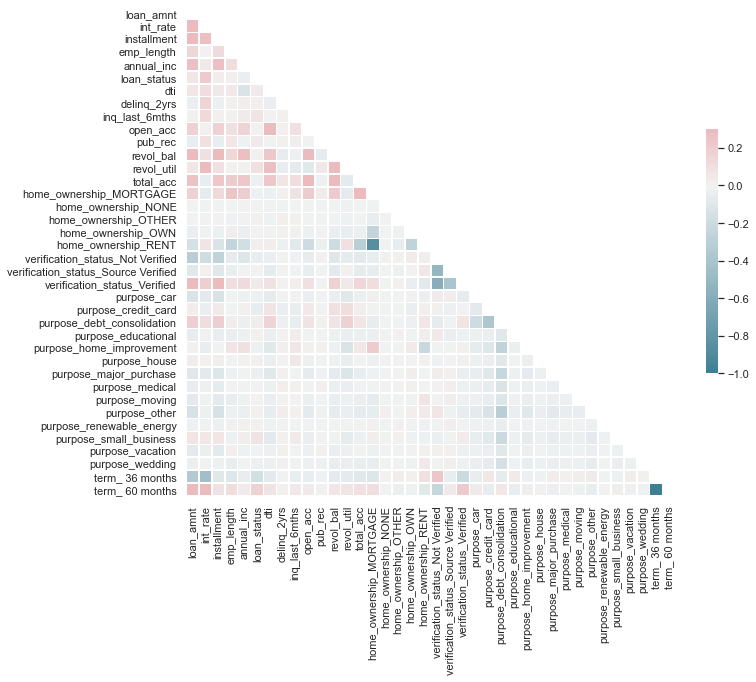

In [26]:
plot_correlation_heatmap(loans)

The solution is to remove one of the dummy columns, although most algorithms are not affected by it.

In [27]:
cat_columns_reduntant = ["home_ownership_NONE", "verification_status_Verified", "purpose_moving", "term_ 36 months"]

loans = loans.drop(cat_columns_reduntant, axis=1)

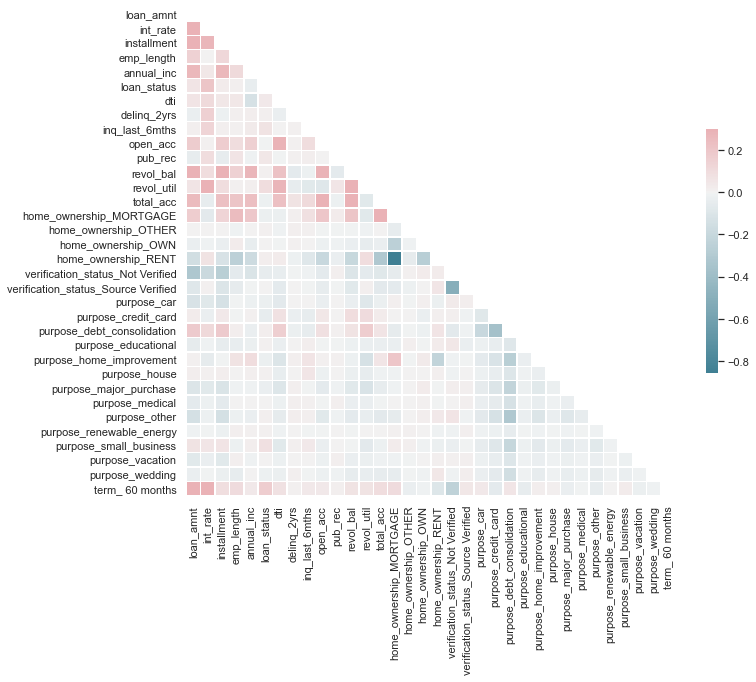

In [28]:
plot_correlation_heatmap(loans)

In [29]:
# Reordering the columns

loans = loans[['loan_amnt', 'int_rate', 'installment', 'emp_length', 'annual_inc',
       'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'home_ownership_MORTGAGE', 'home_ownership_OTHER', 'home_ownership_OWN',
       'home_ownership_RENT', 'verification_status_Not Verified',
       'verification_status_Source Verified', 'purpose_car',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_other',
       'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'term_ 60 months', 'loan_status',]]

In [30]:
loans.to_csv("datasets/loans_clean.csv", index=False)

In [147]:
import pandas as pd
loans = pd.read_csv("datasets/loans_clean.csv")
loans.head()

,loan_amnt,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 60 months,loan_status
0,5000.0,10.65,162.87,10,24000.0,27.65,0.0,1.0,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,2500.0,15.27,59.83,0,30000.0,1.00,0.0,5.0,3.0,0.0,...,0,0,0,0,0,0,0,0,1,1
2,2400.0,15.96,84.33,10,12252.0,8.72,0.0,2.0,2.0,0.0,...,0,0,0,0,0,1,0,0,0,0
3,10000.0,13.49,339.31,10,49200.0,20.00,0.0,1.0,10.0,0.0,...,0,0,0,1,0,0,0,0,0,0
4,5000.0,7.90,156.46,3,36000.0,11.20,0.0,3.0,9.0,0.0,...,0,0,0,0,0,0,0,1,0,0


In [148]:
y = loans["loan_status"]
X = loans.drop("loan_status", axis=1)

First, we will split the data into training and test sets.

In [149]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y==1, test_size=0.2, random_state = 42, stratify=y)

We will also scale the data as machine learning algorithms perform better when the data is in the same range. It's important the scaling is done within the cross validation loop. We will do this in the pipeline when making the training the model.

### Making predictions

The algorithm will make predictions about whether or not a loan will be paid off on time, which is contained in the `loan_status` column.

In [150]:
loans['loan_status'].value_counts(normalize=True)

0    0.856961
1    0.143039
Name: loan_status, dtype: float64

There are 6 times as many loans that were paid off on time (0), than loans that weren't paid off on time (1). As we mentioned earlier, we need to keep the class imbalance in mind as we build machine learning models.

This will be a binary classification problem. Before diving in and selecting an algorithm to apply to the data, we should select an error metric. An error metric will help us figure out when our model is performing well, and when it's performing poorly.

Our objective in this is to make money -- we want to fund enough loans that are paid off on time to offset our losses from loans that aren't paid off.

We're primarily concerned with false positives and false negatives. Both of these are different types of misclassifications. With a false positive, we predict that a loan will default, but it actually isn't. This loses us potential money, since we didn't fund a loan that actually would have been paid off. 

With a false negative, we predict that a loan won't be paid off on time, but it actually would be paid off on time. This costs us money, since we fund loans that lose us money. 

Since we're viewing this problem from the standpoint of a conservative investor, we need to treat false positives differently than false negatives. A conservative investor would want to minimize risk and avoid false positives as much as possible. They'd be more secure with missing out on opportunities (false negatives) than they would be with funding a risky loan (false positives).

Because of the high class imbalance we want to optimize for:

* high recall (true positive rate)
* low fall-out (false positive rate) or (1-specificity)

In order to fit the machine learning models, we'll use the `Scikit-learn` library. 
We will use Random Forests which are able to work with nonlinear data and learn complex conditionals.

To get a classifier to correct for imbalanced classes, we will tell the classifier to penalize misclassifications of the less prevalent class more than the other class.

In [201]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score

#Build pipeline
rf_pipe = Pipeline([("scaler", StandardScaler()),
                    ("classifier", RandomForestClassifier(random_state=42))])

#Train the model
rf_pipe.fit(X_train, y_train)

#Make predictions
pred = rf_pipe.predict(X_test)
print(f"Recall: {recall_score(y_test, pred)}")

Recall: 0.011131725417439703


The score we received is at a threshold of 0.5 which might not be what we need for decision making. The ROC curve shows the performance of a classification model at all classification thresholds. The AUC(area under the curve) higher than 0.5 means our classifier is better than random guessing.

In [202]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)

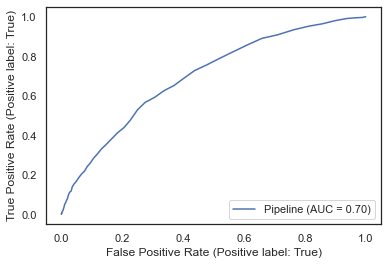

In [204]:
plot_roc_curve(rf_pipe, X_test, y_test);

In order to get a even better understanding at how our classifer does with the minority class, we can look at the confusion matrix.

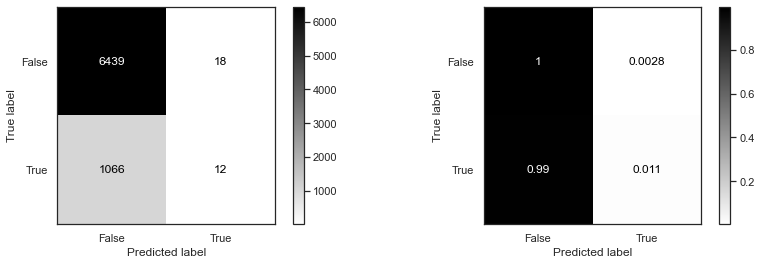

In [159]:
cm = confusion_matrix(y_test, pred)

fig, ax = plt.subplots(1,2, figsize=(14,4))
plot_confusion_matrix(rf_pipe, X_test, y_test, cmap='gray_r', ax=ax[0]);
plot_confusion_matrix(rf_pipe, X_test, y_test, cmap='gray_r', normalize="true", ax=ax[1]);

We can also look at the classification report.

In [160]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.86      1.00      0.92      6457
        True       0.40      0.01      0.02      1078

    accuracy                           0.86      7535
   macro avg       0.63      0.50      0.47      7535
weighted avg       0.79      0.86      0.79      7535



While the model is good at minimizing `False Positives`, meaning we avoid funding bad loans since the model mostly predicts that a loan would be paid off on time, it is doing really poor at catching the loans that are actually going bad with a recall rate of only 0.01. We see this also by looking at the `macro avg` ratio which is 0.5, which means random prediction.

### Hyperparameter optimization

Let's try to optimize the RF classifier and see if we can obtain better results.
We will use GridSearch which searches over specified parameter values for a classifier by using cross-validation.

In [161]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV


#Build pipeline
rf_pipe = Pipeline([("scaler", StandardScaler()),
                    ("classifier", RandomForestClassifier(random_state=42))])

#Instantiate the model
hyperparameters = {"classifier__criterion": ["entropy", "gini"],
                   "classifier__max_depth" : [5,10],
                   "classifier__max_features" : ["log2", "sqrt"],
                   "classifier__min_samples_leaf": [1, 5],
                   "classifier__min_samples_split": [3,5],
                   "classifier__class_weight": [None, "balanced"]
                    }
                   
grid = GridSearchCV(rf_pipe, param_grid = hyperparameters, cv=5, n_jobs=-1, scoring="recall" )
grid.fit(X_train, y_train)

#Make predictions
pred = grid.predict(X_test)

Below we can see the optimized parameters obtained as a result. We can observe that indeed because our data is imbalanced, the model chose to correct for that with the `class_weight` parameter.

In [162]:
best_params = grid.best_params_
best_score = grid.best_score_
print(f'Best_parameters: \n{pd.Series(best_params)}')
print(f'Best score {best_score}')

Best_parameters: 
classifier__class_weight         balanced
classifier__criterion                gini
classifier__max_depth                   5
classifier__max_features             log2
classifier__min_samples_leaf            1
classifier__min_samples_split           5
dtype: object
Best score 0.6167935196113488


Let's dig deeper at how the tuned model performed.

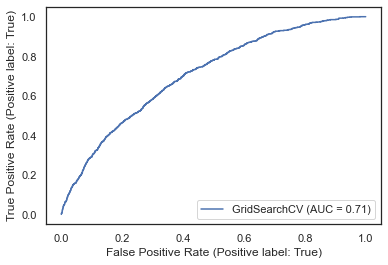

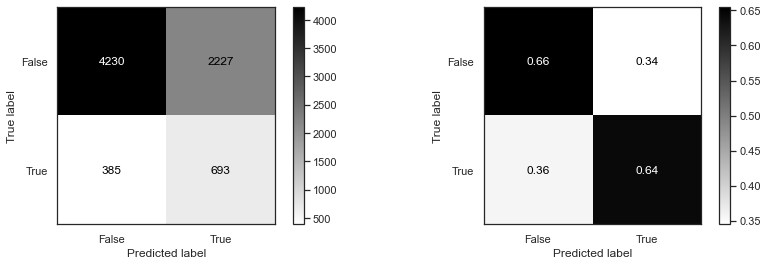

In [163]:
plot_roc_curve(grid, X_test, y_test);

cm = confusion_matrix(y_test, pred)
fig, ax = plt.subplots(1,2, figsize=(14,4))
plot_confusion_matrix(grid, X_test, y_test, cmap='gray_r', ax=ax[0]);
plot_confusion_matrix(grid, X_test, y_test, cmap='gray_r', normalize="true", ax=ax[1]);

In [164]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.92      0.66      0.76      6457
        True       0.24      0.64      0.35      1078

    accuracy                           0.65      7535
   macro avg       0.58      0.65      0.56      7535
weighted avg       0.82      0.65      0.70      7535



We can observe the trade-off between recall and fall-out in action. While we succeded at improving the recall rate, meaning we detect better the loans that will default, we miss more investing in succesful loans.

### Decision making and changing thresholds

Most models provide a probability measure that we can use in order to define a threshold that we can use for our goal – improving the `recall` rate. By default, in binary classifications the threshold is 50%. Below, we predict class `1` whenever our classifier predicts a probability higher than 40%.

In [194]:
y_pred = grid.predict_proba(X_test)[:,1] > 0.4

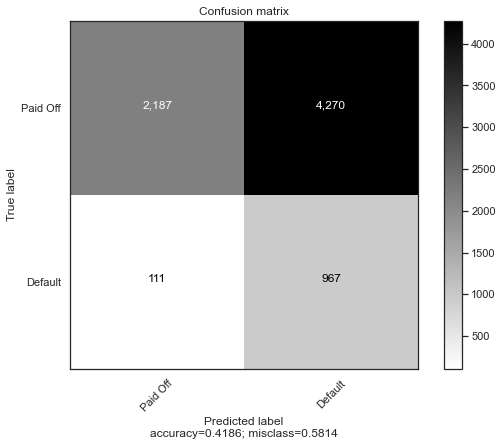

In [195]:
cm = confusion_matrix(y_test, y_pred)
from custom_metrics import custom_plot_confusion_matrix


custom_plot_confusion_matrix(cm, target_names = ['Paid Off', "Default"], normalize=False)

In [196]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.95      0.34      0.50      6457
        True       0.18      0.90      0.31      1078

    accuracy                           0.42      7535
   macro avg       0.57      0.62      0.40      7535
weighted avg       0.84      0.42      0.47      7535



In [197]:
def fallout(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fall_out = fp/(fp+tn)
    return fall_out

print(f'Fall-Out: {fallout(y_test, y_pred)}')

Fall-Out: 0.66129781632337


At a threshold of 40% we improve the recall rate up to 0.9, while we the precision and fall-out fall considerably. As a conservative investors this might be exactly what we want. Even though we miss out on a lot of good loans, if our goal is to preserve our wealth first and foremost then choosing a strategy that minimizes investing in bad loans makes sense.

This analysis is far from over. On way to go from here is trying other algorithms, but even better is speding more time on feature engineering and feature selection. For example, we could use recursive feature elimination (RFE) to select features by recursively considering smaller and smaller sets of features.